In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yfinance as yf
import pandas as pd 

tickers = ['SPY', 'MSFT', 'AAPL', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'ILMN', 'NFLX'] 
df = yf.download(tickers, start = '2018-01-01', end = '2024-12-31', interval='1mo') # use monthly prices
df.head()

[*********************100%%**********************]  10 of 10 completed


Price       Adj Close                                                \
Ticker           AAPL       AMZN       GOOG        ILMN        META   
Date                                                                  
2018-01-01  39.477058  72.544502  58.430511  226.303497  186.506729   
2018-02-01  41.997562  75.622498  55.173714  221.809341  177.954330   
2018-03-01  39.720867  72.366997  51.530861  229.980545  159.462311   
2018-04-01  39.124279  78.306503  50.808681  234.367706  171.647278   
2018-05-01  44.240307  81.481003  54.187836  265.019470  191.386719   

Price                                                               ...  \
Ticker           MSFT        NFLX      NVDA         SPY       TSLA  ...   
Date                                                                ...   
2018-01-01  88.362885  270.299988  6.079518  253.339859  23.620667  ...   
2018-02-01  87.209625  291.380005  5.985531  244.128342  22.870667  ...   
2018-03-01  85.283279  295.350006  5.731613  236.489502  17.742001  ...   
2018-04-01  87.385681  312.459991  5.566043  238.663834  19.593332  ...   
2018-05-01  92.356735  351.600006  6.241442  244.465515  18.982000  ...   

Price           Volume                                                         \
Ticker            AAPL        AMZN       GOOG      ILMN       META       MSFT   
Date                                                                            
2018-01-01  2638717600  1927424000  574768000  21953865  495655700  574258400   
2018-02-01  3711577200  2755680000  847640000  18582845  516251600  725663300   
2018-03-01  2854910800  2608002000  907066000  16350441  996201700  750754800   
2018-04-01  2664617200  2598392000  834318000  20809187  750072700  668130700   
2018-05-01  2483905200  1432310000  636988000  15387515  401144100  509417900   

Price                                                       
Ticker           NFLX         NVDA         SPY        TSLA  
Date                                                        
2018-01-01  238377600  11456216000  1985506700  1864072500  
2018-02-01  184585800  14915528000  2923722000  1637850000  
2018-03-01  263449400  14118440000  2323561800  2359027500  
2018-04-01  262006000  11144008000  1998466500  2854662000  
2018-05-01  142050800  11978240000  1606397200  2333671500  

[5 rows x 60 columns]

In [3]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df.head()

Ticker,Date,SPY,MSFT,AAPL,GOOG,AMZN,TSLA,NVDA,META,ILMN,NFLX
0,2018-01-01,253.339859,88.362885,39.477058,58.430511,72.544502,23.620667,6.079518,186.506729,226.303497,270.299988
1,2018-02-01,244.128342,87.209625,41.997562,55.173714,75.622498,22.870667,5.985531,177.954330,221.809341,291.380005
2,2018-03-01,236.489502,85.283279,39.720867,51.530861,72.366997,17.742001,5.731613,159.462311,229.980545,295.350006
3,2018-04-01,238.663834,87.385681,39.124279,50.808681,78.306503,19.593332,5.566043,171.647278,234.367706,312.459991
4,2018-05-01,244.465515,92.356735,44.240307,54.187836,81.481003,18.982000,6.241442,191.386719,265.019470,351.600006


In [5]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

,unique_id,ds,y
0,SPY,2018-01-01,253.339859
1,SPY,2018-02-01,244.128342
2,SPY,2018-03-01,236.489502
3,SPY,2018-04-01,238.663834
4,SPY,2018-05-01,244.465515
...,...,...,...
795,NFLX,2024-04-01,550.640015
796,NFLX,2024-05-01,641.619995
797,NFLX,2024-06-01,674.880005
798,NFLX,2024-07-01,628.349976


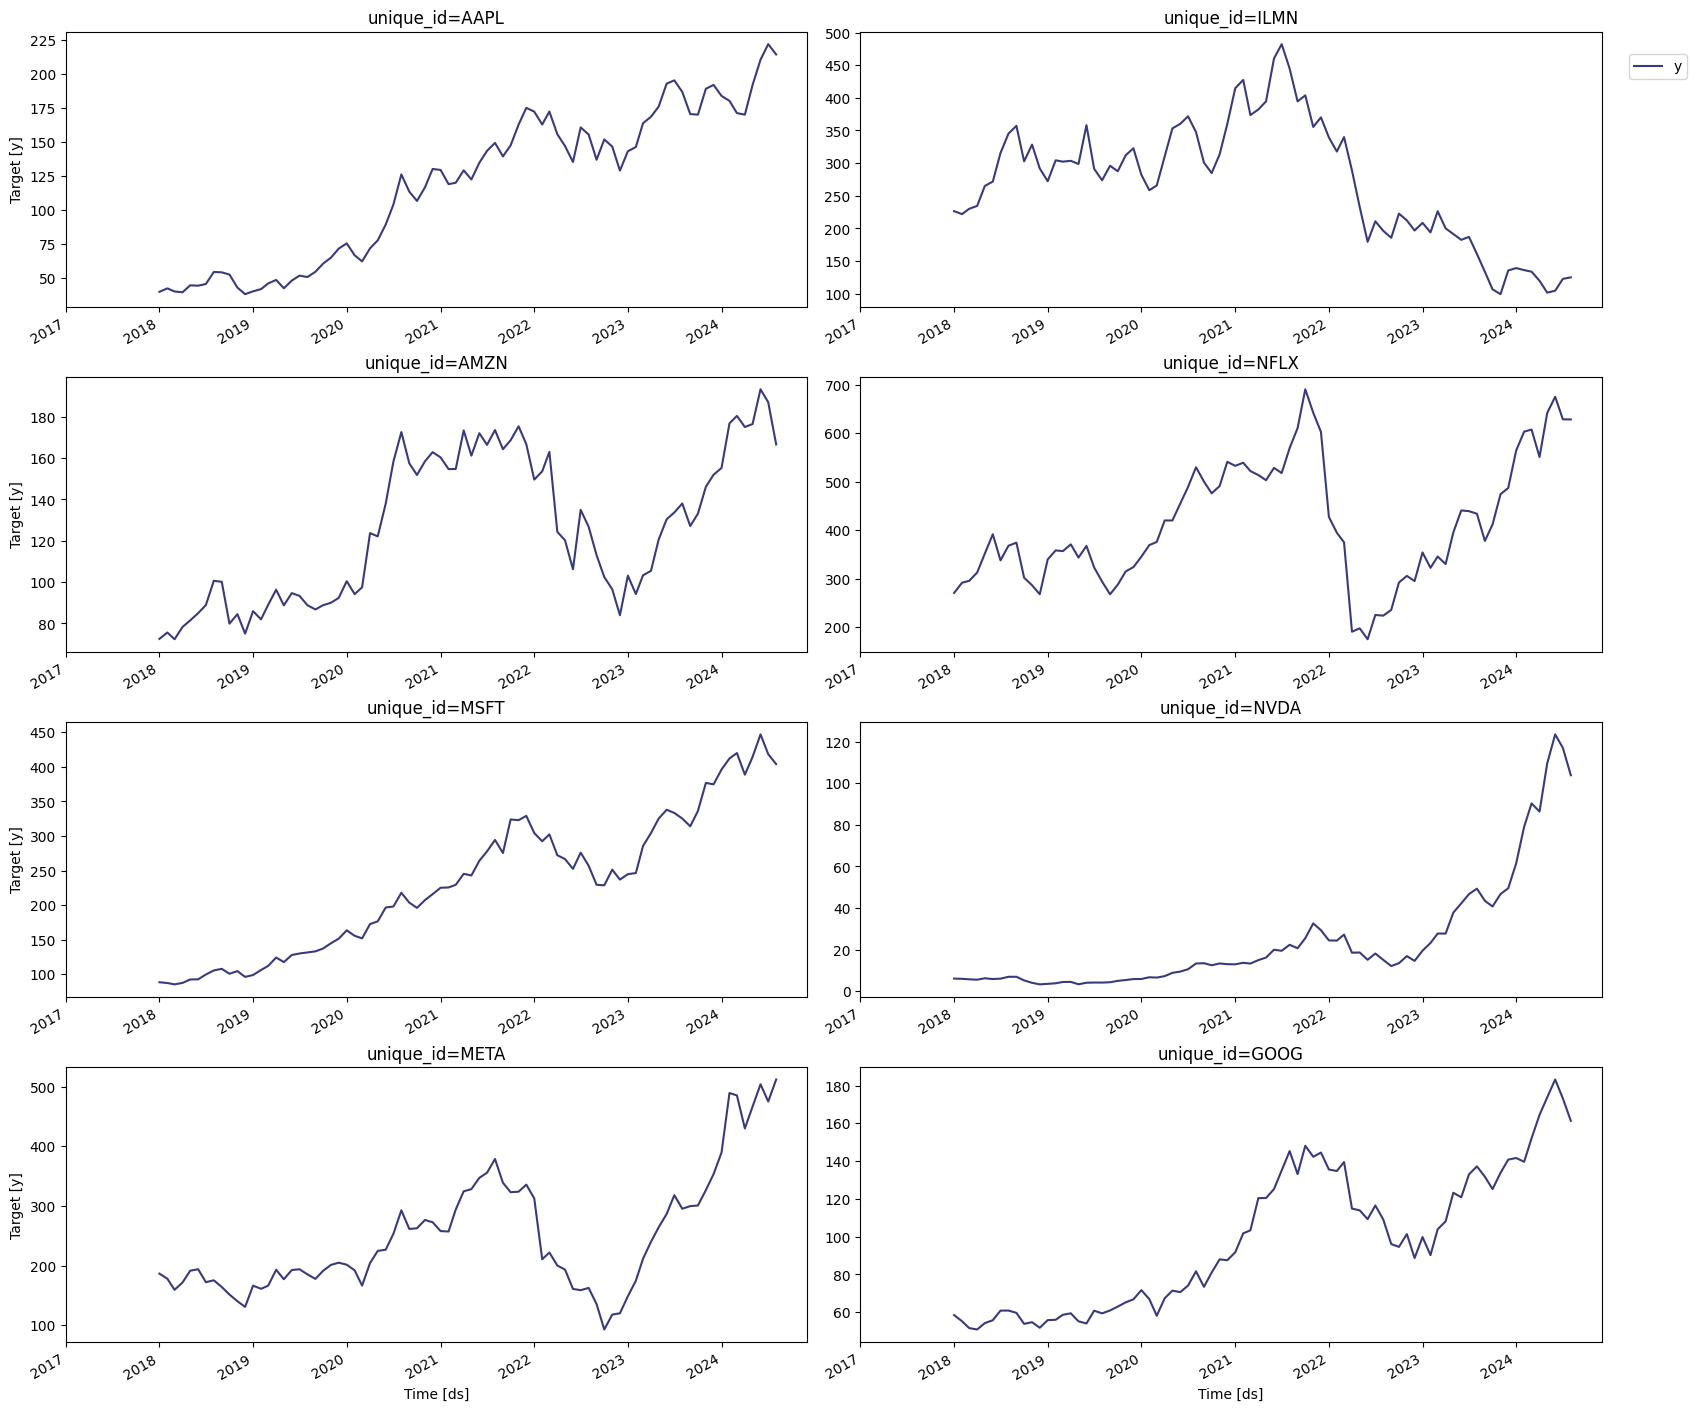

In [6]:
from statsforecast import StatsForecast
StatsForecast.plot(prices)

With the prices, we can compute the logarithmic returns of the S&P 500 and the publicly traded companies. This is the variable we’re interested in since it’s likely to work well with the GARCH framework. The logarithmic return is given by

$return_t = log(price_t/price_(t-1))$

We’ll compute the returns on the price dataframe and then we’ll create a return dataframe with StatsForecast’s format. To do this, we’ll need numpy.

In [7]:
import numpy as np 
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns

,unique_id,ds,y
0,SPY,2018-01-01,NaN
1,SPY,2018-02-01,-0.037038
2,SPY,2018-03-01,-0.031790
3,SPY,2018-04-01,0.009152
4,SPY,2018-05-01,0.024018
...,...,...,...
795,NFLX,2024-04-01,-0.097991
796,NFLX,2024-05-01,0.152915
797,NFLX,2024-06-01,0.050539
798,NFLX,2024-07-01,-0.071438


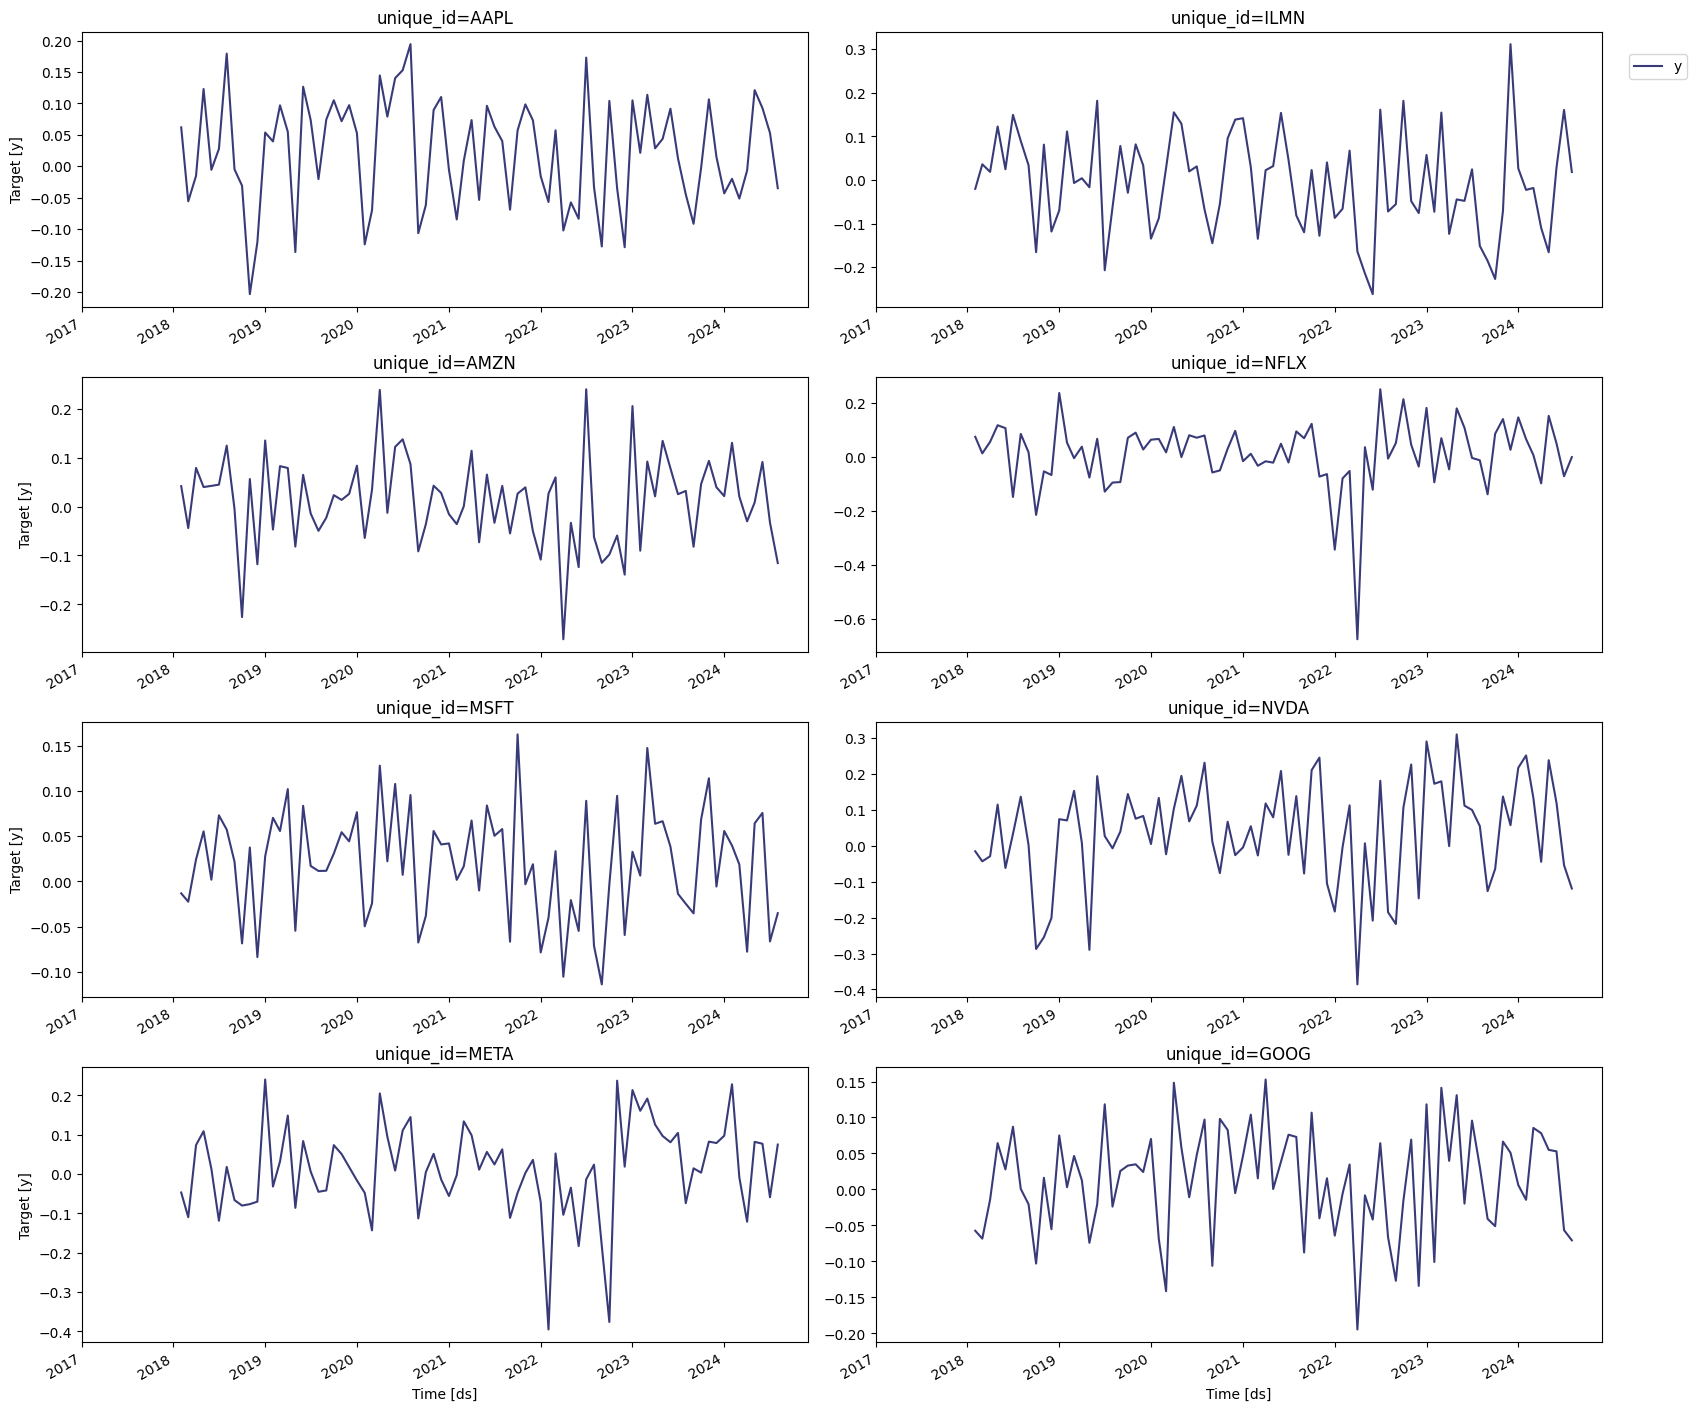

In [8]:
StatsForecast.plot(returns)

In [9]:
from statsforecast.models import (
    GARCH, 
    ARCH, 
    Naive
)

models = [ARCH(1), 
          ARCH(2), 
          GARCH(1,1),
          GARCH(1,2),
          GARCH(2,2),
          GARCH(2,1),
          Naive()
]

In [10]:
sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'MS',
    n_jobs = -1
)

/opt/anaconda3/envs/llm/lib/python3.12/site-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


Time series cross-validation is a method for evaluating how a model would have performed in the past. It works by defining a sliding window across the historical data and predicting the period following it. Here we’ll use StatsForercast’s cross-validation method to determine the most accurate model for the S&P 500 and the companies selected.

This method takes the following arguments:

- df: The dataframe with the training data.
- h (int): represents the h steps into the future that will be forecasted.
- step_size (int): step size between each window, meaning how often do you want to run the forecasting process.
- n_windows (int): number of windows used for cross-validation, meaning the number of forecasting processes in the past you want to evaluate.

> For this particular example, we’ll use 4 windows of 3 months, or all the quarters in a year.

In [11]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

/opt/anaconda3/envs/llm/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [12]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
0,AAPL,2023-09-01,2023-08-01,-0.091510,0.142795,0.142109,0.141138,0.142216,0.142227,0.133108,-0.044658
1,AAPL,2023-10-01,2023-08-01,-0.002573,-0.054836,-0.054151,-0.055026,-0.056274,-0.056274,-0.049764,-0.044658
2,AAPL,2023-11-01,2023-08-01,0.106443,-0.046482,-0.047872,-0.046922,-0.046171,-0.046175,-0.049228,-0.044658
3,AAPL,2023-12-01,2023-11-01,0.014808,0.143803,0.142338,0.143367,0.146160,0.146163,0.132363,0.106443
4,AAPL,2024-01-01,2023-11-01,-0.043145,-0.054596,-0.054783,-0.055534,-0.056200,-0.056203,-0.054138,0.106443


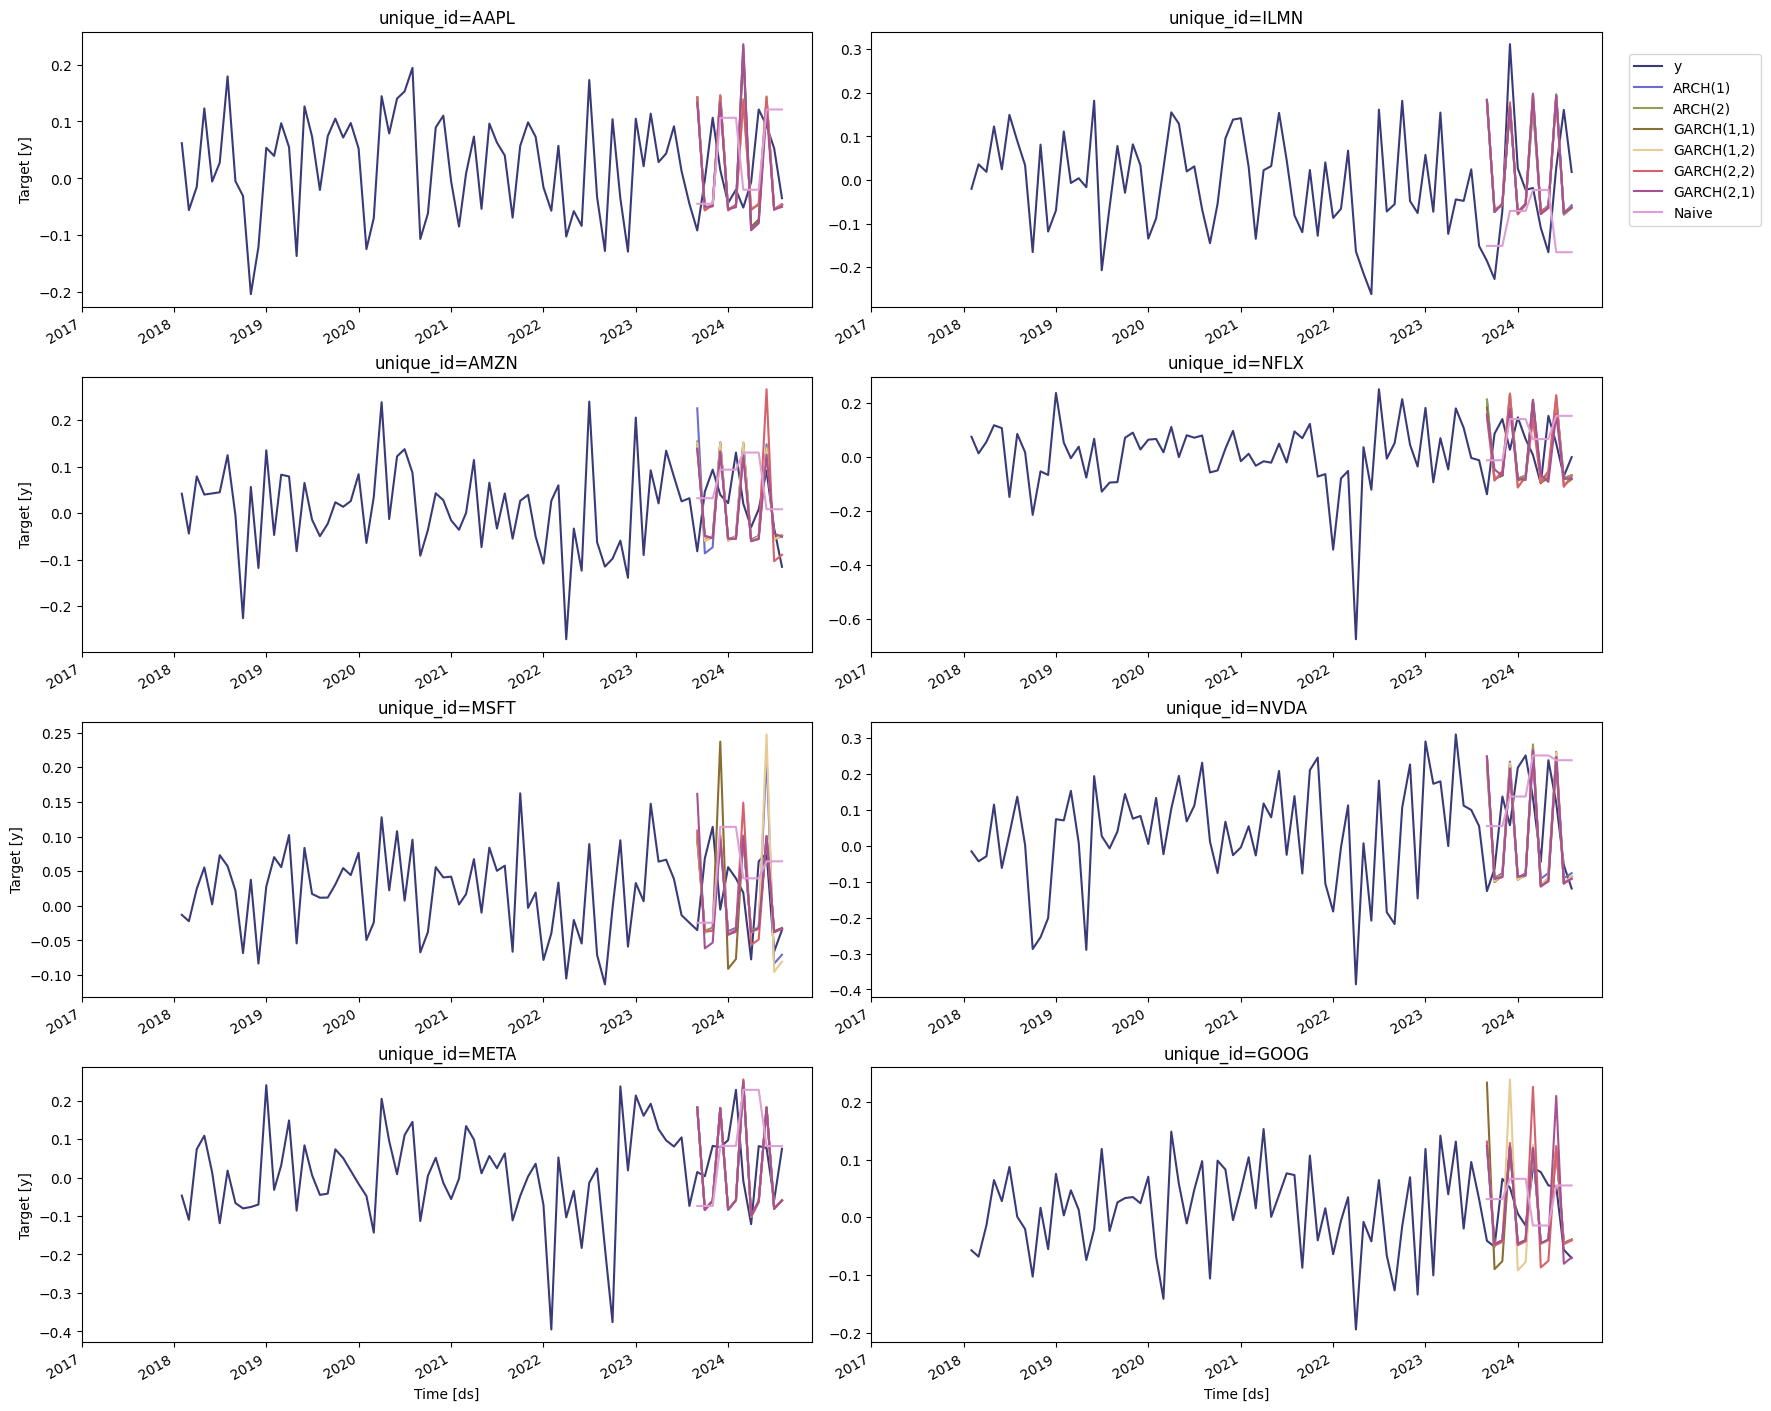

In [13]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

Evaluate results

In [20]:
from datasetsforecast.losses import mae

def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)

In [21]:
mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae.style.highlight_max(color = 'lightblue', axis = 1)

/var/folders/zb/r15p7t_d62d8m2s0623s22gh0000gn/T/ipykernel_96175/508678056.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)


,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
unique_id,,,,,,,
AAPL,0.111452,0.098054,0.109765,0.098683,0.098627,0.109098,0.087149
AMZN,0.111540,0.099792,0.101148,0.101361,0.107217,0.093898,0.082662
GOOG,0.065498,0.065545,0.080566,0.083602,0.082439,0.071581,0.070637
ILMN,0.136102,0.136123,0.136930,0.136846,0.136975,0.137332,0.138132
META,0.137503,0.137826,0.137504,0.137591,0.137589,0.137824,0.114268
MSFT,0.088302,0.076975,0.097760,0.095375,0.082980,0.086953,0.074807
NFLX,0.162275,0.162837,0.165295,0.158033,0.158034,0.154268,0.113568
NVDA,0.173683,0.178041,0.183456,0.182265,0.180596,0.180067,0.154404
SPY,0.091286,0.064873,0.058477,0.057692,0.074158,0.061705,0.045369


Generate a forecast for the next quarter

In [22]:
levels = [80, 95] # confidence levels for the prediction intervals 

forecasts = sf.forecast(h=3, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

/opt/anaconda3/envs/llm/lib/python3.12/site-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/opt/anaconda3/envs/llm/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,ARCH(1),ARCH(1)-lo-95,ARCH(1)-lo-80,ARCH(1)-hi-80,ARCH(1)-hi-95,ARCH(2),ARCH(2)-lo-95,ARCH(2)-lo-80,...,"GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-lo-80","GARCH(2,1)-hi-80","GARCH(2,1)-hi-95",Naive,Naive-lo-80,Naive-lo-95,Naive-hi-80,Naive-hi-95
0,AAPL,2024-09-01,0.137615,0.123547,0.128416,0.146813,0.151682,0.136875,0.122958,0.127775,...,0.134061,0.120711,0.125332,0.142791,0.147412,-0.034821,-0.180717,-0.257950,0.111075,0.188307
1,AAPL,2024-10-01,-0.053019,-0.067741,-0.062645,-0.043393,-0.038298,-0.051766,-0.065800,-0.060943,...,-0.047888,-0.059898,-0.055741,-0.040035,-0.035878,-0.034821,-0.241149,-0.350373,0.171507,0.280730
2,AAPL,2024-11-01,-0.044840,-0.058967,-0.054077,-0.035604,-0.030714,-0.046722,-0.062059,-0.056750,...,-0.048871,-0.065652,-0.059843,-0.037899,-0.032091,-0.034821,-0.287520,-0.421291,0.217878,0.351649
3,AMZN,2024-09-01,0.147877,0.131633,0.137256,0.158499,0.164121,0.141921,0.126959,0.132138,...,0.126610,0.114703,0.118824,0.134396,0.138518,-0.115527,-0.290628,-0.383322,0.059574,0.152267
4,AMZN,2024-10-01,-0.055693,-0.071937,-0.066315,-0.045072,-0.039449,-0.057655,-0.075063,-0.069037,...,-0.057894,-0.075447,-0.069371,-0.046416,-0.040341,-0.115527,-0.363158,-0.494246,0.132104,0.263191


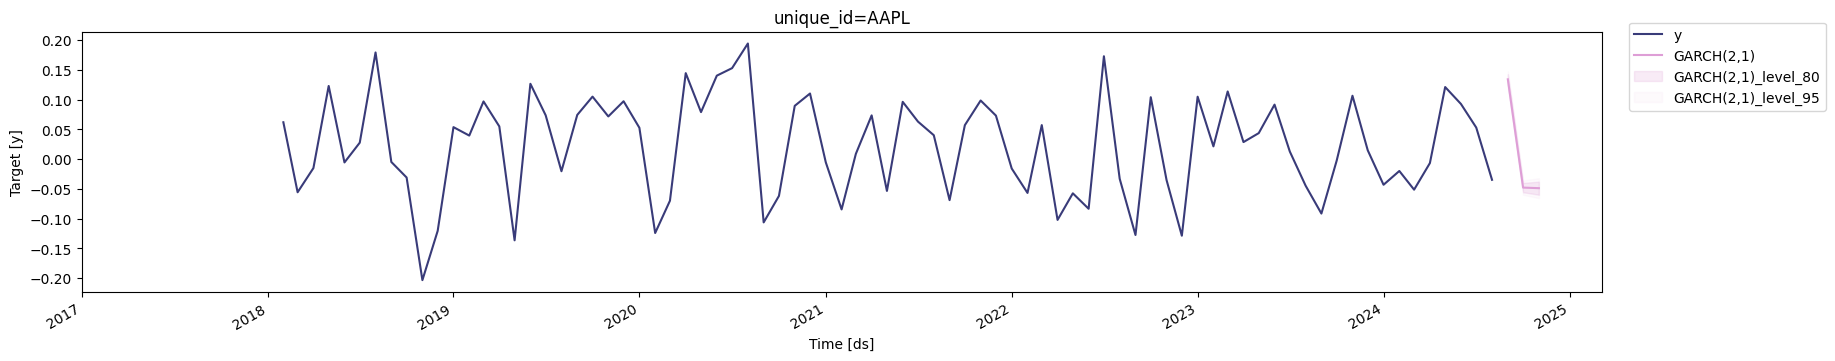

In [23]:
StatsForecast.plot(returns, forecasts, level=levels, unique_ids = ['AAPL'], models = ['GARCH(2,1)'])

In [32]:
forecasts[forecasts['unique_id'] == 'AAPL'][[col for col in forecasts[forecasts['unique_id'] == 'AAPL'].columns if "GARCH(2,1)" in col]]

,"GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-lo-80","GARCH(2,1)-hi-80","GARCH(2,1)-hi-95"
0,0.134061,0.120711,0.125332,0.142791,0.147412
1,-0.047888,-0.059898,-0.055741,-0.040035,-0.035878
2,-0.048871,-0.065652,-0.059843,-0.037899,-0.032091


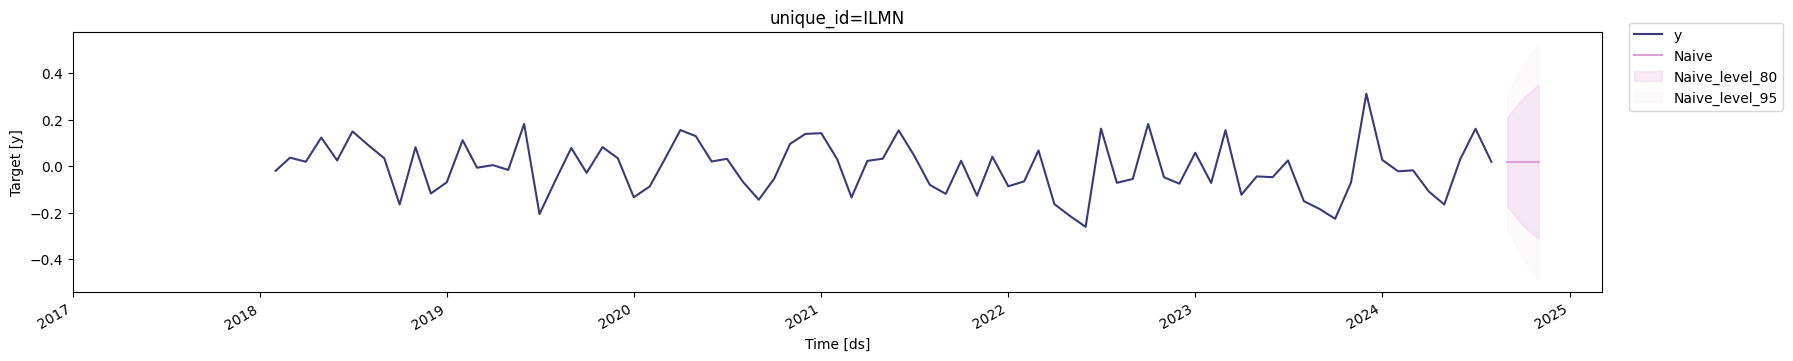

In [31]:
StatsForecast.plot(returns, forecasts, level=levels, unique_ids = ['ILMN'], models = ['Naive'])

In [30]:
forecasts[forecasts['unique_id'] == 'ILMN'][[col for col in forecasts[forecasts['unique_id'] == 'ILMN'].columns if "Naive" in col]]

,Naive,Naive-lo-80,Naive-lo-95,Naive-hi-80,Naive-hi-95
9,0.018506,-0.173897,-0.275750,0.210910,0.312762
10,0.018506,-0.253593,-0.397634,0.290606,0.434647
11,0.018506,-0.314747,-0.491160,0.351759,0.528173


In [33]:
from typing import List
from datetime import datetime
import yfinance as yf
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from statsforecast.models import (
    GARCH, 
    ARCH, 
    Naive
)
from datasetsforecast.losses import mae

class Forecaster:
    def __init__(self, tickers: List[str]):
        self.df = yf.download(
            tickers, 
            start = (
                datetime.now() - relativedelta(years=10)
            ).strftime("%Y-%m-%d"), 
            end = datetime.today().strftime("%Y-%m-%d"), 
            interval='1mo') # use monthly prices
        
        self.models = [
            ARCH(1), 
            ARCH(2), 
            GARCH(1,1),
            GARCH(1,2),
            GARCH(2,2),
            GARCH(2,1),
            Naive()
        ]
    def post__init__(self):
        ## Prepare dataframe
        self.df = df.loc[:, (['Adj Close'], tickers)]
        self.df.columns = self.df.columns.droplevel() # drop MultiIndex
        self.df = self.df.reset_index()
        
        ## Prepare target dataframe
        prices = self.df.melt(id_vars = 'Date')
        prices = prices.rename(
            columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'}
        )
        prices = prices[['unique_id', 'ds', 'y']]
        prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
        prices['rt'] = np.log(prices['rt'])
        returns = prices[['unique_id', 'ds', 'rt']]
        returns = returns.rename(columns={'rt':'y'})
    
        self.sf = StatsForecast(
            df = returns, 
            models = self.models, 
            freq = 'MS',
            n_jobs = -1)
        
        ## Prepare cross-validation dataframe
        self.crossvalidation_df = self.sf.cross_validation(
            df = returns,
            h = 3,
            step_size = 3,
            n_windows = 4
        )
        self.crossvalidation_df = self.crossvalidation_df.reset_index()
        self.crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
    
    def evaluate(self):
        mae_cv = self.crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(self.compute_cv_mae)
        self.mae = self.mae_cv.groupby('unique_id').mean()
    
    def show_max(self):
        self.mae.style.highlight_max(color = 'lightblue', axis = 1)
    
    @staticmethod
    def compute_cv_mae(crossvalidation_df: pd.DataFrame):
        """Compute MAE for all models generated"""
        res = {}
        for mod in models: 
            res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
        return pd.Series(res)
    
    def plot_post_init(self):
        """Plots forecast against actual test results.
        For debugging purposes"""
        try:
            StatsForecast.plot(
                self.returns, 
                self.crossvalidation_df.drop(['cutoff', 'actual'],
                    axis=1))
        except:
            self.post_init()
            StatsForecast.plot(
                self.returns, 
                self.crossvalidation_df.drop(['cutoff', 'actual'],
                    axis=1))

In [37]:
datetime.now() - relativedelta(years=10)

datetime.datetime(2014, 8, 10, 9, 28, 24, 391644)